In [ ]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import pandas as pd
import os

SEED = 50
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

class TaskOffloadingEnv(gym.Env):
    def __init__(self, n_vehicles, d_V_values, bar_d_V_values, F_C=20e9, max_steps=100):
        super(TaskOffloadingEnv, self).__init__()
        self.n = n_vehicles
        self.d_V_values = d_V_values
        self.bar_d_V_values = bar_d_V_values
        self.F_C = F_C
        self.max_steps = max_steps
        self.current_step = 0

        self.action_space = spaces.Tuple((
            spaces.MultiBinary(self.n),
            spaces.Box(low=2e9, high=4e9, shape=(self.n,), dtype=np.float32)
        ))

        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(7 * self.n,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.d_V = np.random.choice(self.d_V_values, self.n) * 8
        self.c_V = np.random.randint(5, 6, self.n) * 1e3 / 8
        self.tau_V = np.random.randint(5, 6, self.n)
        self.bar_d_V = np.random.choice(self.bar_d_V_values, self.n) * 8
        self.f_V = np.random.randint(1, 2, self.n) * 1e9
        self.T_upload_C = np.random.randint(200, 201, self.n) * 1e6
        self.T_download_C = np.random.randint(400, 401, self.n) * 1e6

        return np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, self.T_upload_C, self.T_download_C])

    def step(self, action):
        self.current_step += 1

        x_V, F_C_V = action
        x_V = x_V.reshape(-1)
        F_C_V = F_C_V.flatten()

        T_total = 0
        for i in range(self.n):
            if x_V[i] == 0:
                T_V_i = (self.d_V[i] * self.c_V[i]) / self.f_V[i]
            else:
                T_V_i = (self.d_V[i] / self.T_upload_C[i]) + \
                        ((self.d_V[i] * self.c_V[i]) / (F_C_V[i])) + \
                        (self.bar_d_V[i] / self.T_download_C[i]) + 2*0.003

            T_total += T_V_i

        x_V = torch.as_tensor(x_V, dtype=torch.float32)
        F_C_V = torch.as_tensor(F_C_V, dtype=torch.float32)

        if torch.sum(x_V * F_C_V) > self.F_C:
            reward = -1e11
        else:
            reward = -T_total

        next_state = np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, self.T_upload_C, self.T_download_C])
        done = self.current_step >= self.max_steps

        return next_state, reward, done, {}

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, std=0.2):
        super(ActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.actor_fc = nn.Linear(hidden_size, num_actions)
        self.actor_fc2 = nn.Linear(hidden_size, num_actions)
        self.critic = nn.Linear(hidden_size, 1)
        self.log_std = nn.Parameter(torch.ones(1, num_actions) * std)
        
    def forward(self, x):
        x = self.common(x)

        probs = torch.sigmoid(self.actor_fc(x))
        means = self.actor_fc2(x)
        stds = self.log_std.expand_as(means)

        value = self.critic(x)

        return probs, means, stds, value

def compute_returns(next_value, rewards, masks, gamma):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

def ppo_update(model, optimizer, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, entropy_coefficient, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist_probs, means, stds, value = model(state)
            action_continuous = action[:, n_vehicles:]

            dist_normal = Normal(means, stds)
            new_log_prob_continuous = dist_normal.log_prob(action_continuous).sum(1, keepdim=True)

            action_discrete = action[:, :n_vehicles]
            dist_categorical = Categorical(logits=dist_probs)

            action_discrete_i_list = []
            new_log_prob_discrete_list = []
            for i in range(n_vehicles):
                action_discrete_i = action_discrete[:, i]
                action_discrete_i_list.append(action_discrete_i.unsqueeze(-1))
                new_log_prob_discrete_i = dist_categorical.log_prob(action_discrete_i)
                new_log_prob_discrete_list.append(new_log_prob_discrete_i.unsqueeze(-1))

            new_action_discrete_i = torch.cat(action_discrete_i_list, dim=-1)
            new_log_prob_discrete_i = torch.cat(new_log_prob_discrete_list, dim=-1)

            new_log_probs = new_log_prob_discrete_i + new_log_prob_continuous

            ratio = (new_log_probs / (old_log_probs))
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            optimizer.zero_grad()
            entropy = dist_categorical.entropy().mean() + dist_normal.entropy().mean()
            total_loss = actor_loss + 0.5 * critic_loss - entropy_coefficient * entropy
            
            total_loss.backward()

            max_norm = 0.5
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

def evaluate_policy(env, model, n_vehicles, episodes=2):
    total_latency = 0.0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                dist_probs, means, stds, _ = model(state)
                action_cat = Categorical(dist_probs)
                action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
                action_discrete = action_discrete.reshape(1, n_vehicles)
                action_continuous = Normal(means, stds).sample()
                action = (action_discrete, action_continuous.numpy())
            next_state, reward, done, _ = env.step(action)
            total_latency += -reward
            state = next_state

    average_latency = total_latency / episodes
    return average_latency

def run_experiment(n_vehicles, learning_rate, entropy_coefficient, gamma, d_V_values, bar_d_V_values):
    env = TaskOffloadingEnv(n_vehicles=n_vehicles, d_V_values=d_V_values, bar_d_V_values=bar_d_V_values)
    num_inputs = env.observation_space.shape[0]
    num_actions = n_vehicles
    minimum_batch_size=64
    model = ActorCritic(num_inputs, num_actions, hidden_size=512)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    max_frames = 1000
    frame_idx = 0
    latencies = []
    epochs_recorded = []

    state = env.reset()
    best_latency = float('inf')
    
    while frame_idx < max_frames:
        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []
    
        for _ in range(100):
            state = torch.FloatTensor(state).unsqueeze(0)
            dist_probs, means, stds, value = model(state)
            dist_probs = dist_probs.squeeze(0)
            action_cat = Categorical(logits=dist_probs)
            action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
            action_discrete = action_discrete.reshape(1, n_vehicles)
            action_continuous = Normal(means, stds).sample()
            action_continuous_np = action_continuous.numpy()
            action = (action_discrete, action_continuous_np)
            next_state, reward, done, _ = env.step(action)
            log_prob = action_cat.log_prob(action_discrete) + Normal(means, stds).log_prob(action_continuous).sum(1, keepdim=True)
            
            states.append(state)
            actions.append(torch.cat([action_discrete, action_continuous], 1))
            rewards.append(reward)
            masks.append(1 - done)
            values.append(value)
            log_probs.append(log_prob)
    
            state = next_state
            frame_idx += 1
    
            if done:
                state = env.reset()
    
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        with torch.no_grad():
            _, _, _, next_value = model(next_state)
            
        returns = compute_returns(next_value, rewards, masks, gamma)
        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values = torch.cat(values).detach()
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantage = returns - values
        ppo_epoch = 4
        ppo_update(model, optimizer, ppo_epoch, minimum_batch_size, states, actions, log_probs, returns, advantage, entropy_coefficient)
    
        if frame_idx % 100 == 0:
            latency = evaluate_policy(env, model, n_vehicles)
            latencies.append(latency)
            epochs_recorded.append(frame_idx)
            avg_latency = np.mean(latencies[-100:])
            if avg_latency <= best_latency:
                best_latency = avg_latency

    config_label = f'n={n_vehicles}, lr={learning_rate}, hcoeff={entropy_coefficient}, gamma={gamma}, d_V={d_V_values}, bar_d_V={bar_d_V_values}'
    data = pd.DataFrame({
    'Iteration': epochs_recorded,
    'Latency at ' + config_label: latencies
    })
    all_results.append(data)

all_results = []
n_vehicles_options = [10, 50, 100]
d_V_options = [31000, 310000, 3100000] #31kbyte, 310kbyte, and 3.1Mbyte
bar_d_V_options = [15500, 155000, 1550000]#15.5kbyte, 155 kbyte, 1.55Mbyte 
best_configs = {
    10: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    50: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    100: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)]
}

for n_vehicles in n_vehicles_options:
    for d_V in d_V_options:
        for bar_d_V in bar_d_V_options:
            for config in best_configs[n_vehicles]:
                learning_rate, entropy_coefficient, gamma = config
                print(f'Starting experiment with {n_vehicles} vehicles, learning rate {learning_rate}, '
                      f'entropy coefficient {entropy_coefficient}, and discount factor {gamma}, '
                      f'task size {d_V}, result size {bar_d_V}')
                run_experiment(n_vehicles, learning_rate, entropy_coefficient, gamma, [d_V], [bar_d_V])

combined_results = pd.concat(all_results)
file_path = 'latency_vs_vehicles_task_result_sizes.csv'
combined_results.to_csv(file_path, index=False)
   


    Vehicles  Task Size  Result Size  Latency (ms)
0         10      31000        15500  1.335000e+12
1         10      31000       155000  4.437500e+11
2         10      31000      1550000  7.574999e+11
3         10     310000        15500  1.485000e+12
4         10     310000       155000  4.593749e+11
5         10     310000      1550000  1.953125e+12
6         10    3100000        15500  1.246875e+12
7         10    3100000       155000  2.744375e+12
8         10    3100000      1550000  2.213751e+12
9         50      31000        15500  2.760625e+12
10        50      31000       155000  2.834375e+12
11        50      31000      1550000  1.971875e+12
12        50     310000        15500  5.905442e+12
13        50     310000       155000  1.971251e+12
14        50     310000      1550000  1.735625e+12
15        50    3100000        15500  2.768751e+12
16        50    3100000       155000  3.478126e+12
17        50    3100000      1550000  2.748122e+12
18       100      31000        

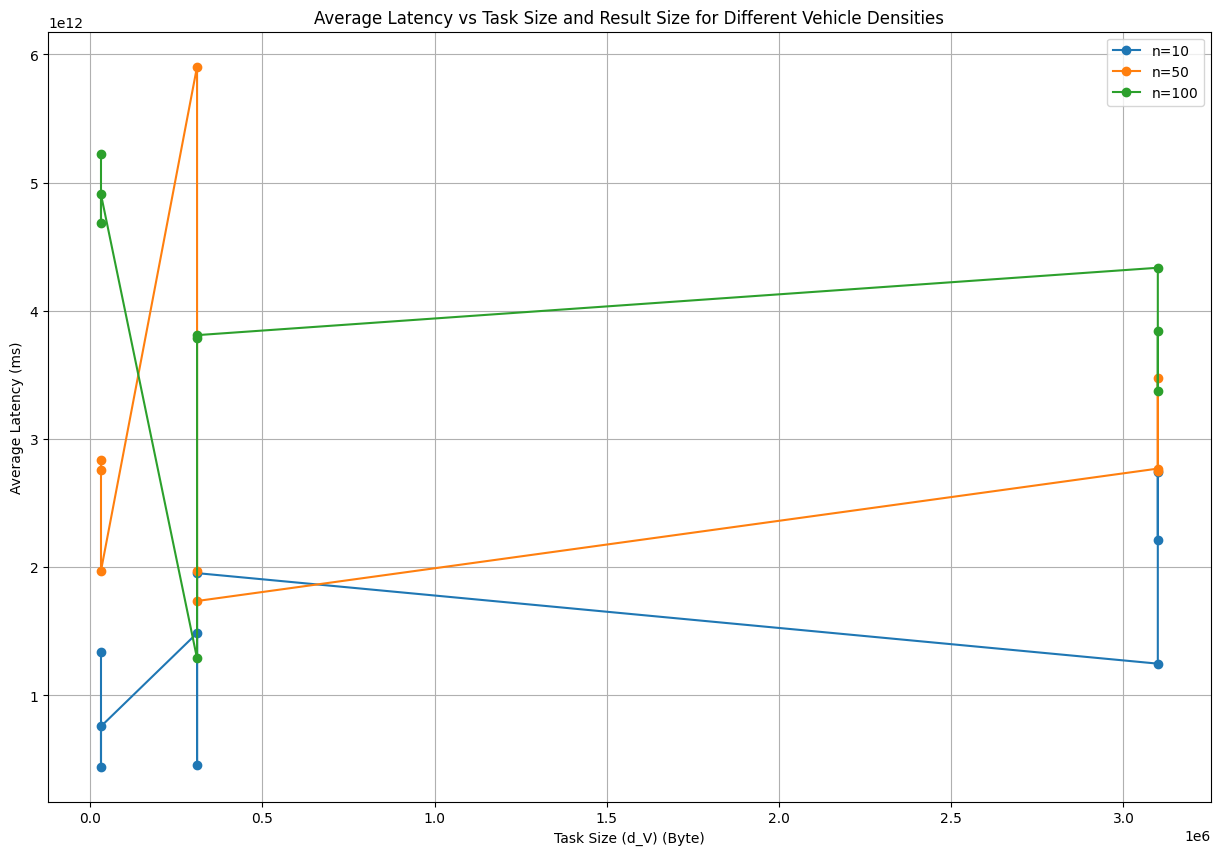

In [4]:
# Extract the task size and result size from the column names
combined_results_melted = combined_results.melt(id_vars=['Iteration'], var_name='Configuration', value_name='Latency (ms)')
combined_results_melted['Vehicles'] = combined_results_melted['Configuration'].str.extract(r'n=(\d+)').astype(int)
combined_results_melted['Task Size'] = combined_results_melted['Configuration'].str.extract(r'd_V=\[(\d+)\]').astype(int)
combined_results_melted['Result Size'] = combined_results_melted['Configuration'].str.extract(r'bar_d_V=\[(\d+)\]').astype(int)

# Group by the number of vehicles, task size, and result size and calculate the average latency
average_latencies = combined_results_melted.groupby(['Vehicles', 'Task Size', 'Result Size'])['Latency (ms)'].mean().reset_index()

print(average_latencies)
plt.figure(figsize=(15, 10))
for n_vehicles in n_vehicles_options:
    subset = average_latencies[average_latencies['Vehicles'] == n_vehicles]
    plt.plot(subset['Task Size'], subset['Latency (ms)'], marker='o', label=f'n={n_vehicles}')

plt.title("Average Latency vs Task Size and Result Size for Different Vehicle Densities")
plt.xlabel("Task Size (d_V) (Byte)")
plt.ylabel("Average Latency (ms)")
plt.grid(True)
plt.legend()
plt.show()